In [1]:
import bnpy
import numpy as np
import util
import time, os
import PlotHelper
from matplotlib import pyplot as plt

In [2]:
task_ids = {25: 3, 50: 2, 100: 1} #, 200: 2
L_vals = [0, 1, 4, 16]
K_vals = task_ids.keys()
sparse_algs = ['zeropass', 'onepass', 'twopass']
paths = {K: 'experiments/mocap124-K%d' % K for K in K_vals}
n_reps = 100
n_data = 5
use_single_seq = False

# Load data

In [3]:
dataset = util.load_full_mocap_data()

Pick `n_data` longest sequences.

In [4]:
# Compute lengths of sequence
timesteps = dataset.doc_range[1:] - dataset.doc_range[:-1]

# Make subset
longest_idx = np.argpartition(timesteps, dataset.nDoc - n_data)[-n_data:]
data_subset = dataset.make_subset(longest_idx)

# Make one long sequence from n_data sequences
if use_single_seq:
    data_subset.doc_range = np.array([0, data_subset.doc_range[-1]])
    data_subset.nDoc = 1

print 'Overall shape:', data_subset.X.shape
print 'Number of sequences:', data_subset.nDoc
print 'Sequence lengths:', timesteps[longest_idx]

Overall shape: (3638, 12)
Number of sequences: 5
Sequence lengths: [ 451  461  466  777 1483]


# Load model

Time local step on the `n_data` longest sequences (or a single long sequence, depending on whether `use_single_seq` is true). For each `sparse_alg`, $K$, and $L$, repeat experiment multiple times, then report the median.

## E step

In [5]:
def time_local_step(dataset, K, L, sparse_opt, n_reps, path_prefix):
    # Determine path to model files
    if L == 0:
        path_suffix = 'dense'
    elif L == 1:
        path_suffix = 'onepass-L=1'
    else:
        path_suffix = '%s-L=%d' % (sparse_opt, L)
    path = os.path.join(path_prefix, path_suffix, str(task_ids[K]))
    #print path
    
    # Load allocModel and obsModel
    model, _ = bnpy.load_model_at_lap(path, None)
    alloc_model = model.allocModel
    obs_model = model.obsModel
    
    # Compute logSoftEv
    LP = obs_model.calc_local_params(dataset)
    
    # Run timing experiment n_reps times
    time_list = []
    for rep in xrange(n_reps):
        t0 = time.time()
        _ = alloc_model.calc_local_params(dataset, LP, L, sparse_opt)
        elapsed_time = time.time() - t0
        time_list.append(elapsed_time)
    return np.median(time_list)

In [6]:
def run_experiment(time_fn, dataset, K_vals, L_vals, sparse_algs):
    time_data = np.zeros((len(sparse_algs), len(K_vals), len(L_vals)))
    for j, K in enumerate(K_vals):
        for k, L in enumerate(L_vals):
            for i, sparse_opt in enumerate(sparse_algs):
                if L <= 1 and i > 0: break
                time_data[i, j, k] = time_fn(dataset, K, L, sparse_opt, n_reps, paths[K])
    return {'y': time_data, 'x': K_vals}

In [14]:
local_res = run_experiment(time_local_step, data_subset, K_vals, L_vals, sparse_algs)

In [24]:
def plot_res(res, K_vals, L_vals, sparse_algs, is_local_step=True, ymax=None, show_legend=True):
    linewidth = 3
    linestyles = {'zeropass': '.-',
                  'onepass': '.-.',
                  'twopass': '.--'}
    alg_str = {'zeropass': 'Likelihood',
               'onepass': 'Beam search',
               'twopass': 'Posterior'}
    labels = []
    title = 'Local step time vs K' if is_local_step else 'Summary step time vs K'
    
    for i, sparse_alg in enumerate(sparse_algs):
        for j, L in enumerate(L_vals):
            if L == 0:
                if i > 0: continue
                linestyle = 's-'
                color = 'gray'
                label = 'Dense L = K'
                markersize = 10
            elif L == 1:
                if i > 0: continue
                linestyle = 'd-'
                color = 'green'
                label = 'Viterbi L = 1'
                markersize = 10
            else:
                linestyle = linestyles[sparse_alg]
                color = PlotHelper.Colors[len(L_vals)-j-1]
                label = '%s L = %d' % (alg_str[sparse_alg], L)
                markersize = 15
                
            plt.plot(res['x'], res['y'][i,:,j], linestyle,
                     linewidth=linewidth, markersize=markersize, color=color)
            labels.append(label)
            
    if ymax is not None: plt.ylim(0, ymax)
    if show_legend: plt.legend(loc='upper left', labels=labels, fontsize=15, markerscale=0)
    plt.gcf().set_size_inches((8, 8))
    plt.xlabel('num clusters K')
    plt.ylabel('time (sec)')
    plt.xticks([25, 50, 75, 100])
    plt.title(title)
    plt.show()

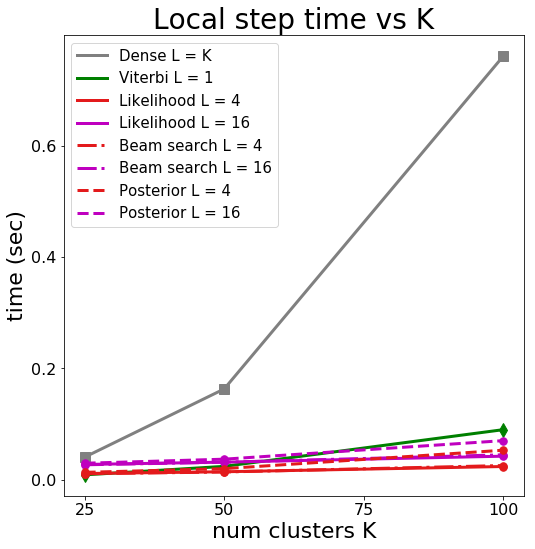

In [25]:
plot_res(local_res, K_vals, L_vals, sparse_algs, is_local_step=True, show_legend=True)

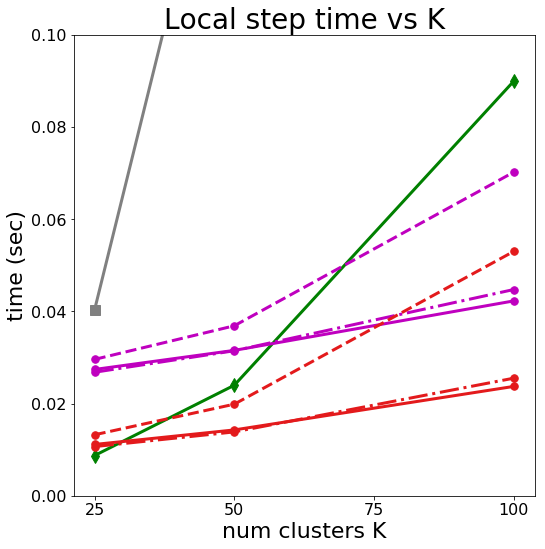

In [17]:
plot_res(local_res, K_vals, L_vals, sparse_algs, is_local_step=True, ymax=0.1, show_legend=False)

## M step

In [18]:
def time_summary_step(dataset, K, L, sparse_opt, n_reps, path_prefix):
    # Determine path to model files
    if L == 0:
        path_suffix = 'dense'
    elif L == 1:
        path_suffix = 'onepass-L=1'
    else:
        path_suffix = '%s-L=%d' % (sparse_opt, L)
    path = os.path.join(path_prefix, path_suffix, str(task_ids[K]))
    #print path
    
    # Load allocModel and obsModel
    model, _ = bnpy.load_model_at_lap(path, None)
    alloc_model = model.allocModel
    obs_model = model.obsModel
    
    # Compute sparse resp (spR)
    LP = obs_model.calc_local_params(dataset)
    LP = alloc_model.calc_local_params(dataset, LP, L, sparse_opt)
    
    # Run timing experiment n_reps times
    time_list = []
    for rep in xrange(n_reps):
        t0 = time.time()
        _ = obs_model.get_global_suff_stats(dataset, None, LP)
        elapsed_time = time.time() - t0
        time_list.append(elapsed_time)
    return np.median(time_list)

In [22]:
summary_res = run_experiment(time_summary_step, data_subset, K_vals, L_vals, sparse_algs)

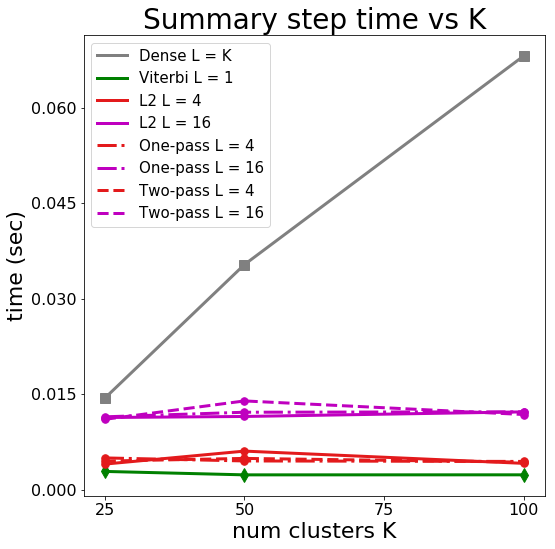

In [20]:
plot_res(summary_res, K_vals, L_vals, sparse_algs, is_local_step=False, show_legend=True)

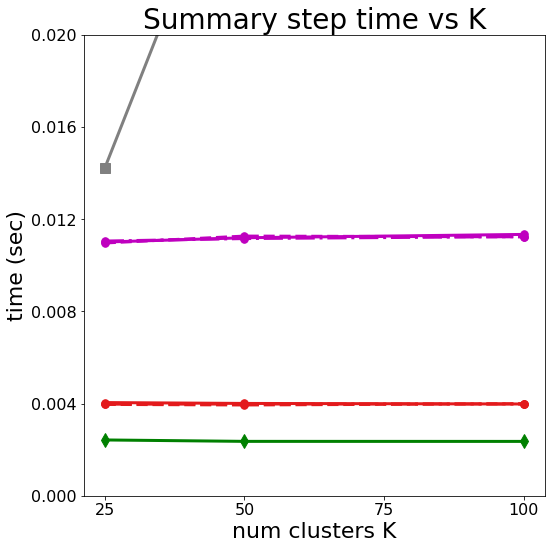

In [23]:
plot_res(summary_res, K_vals, L_vals, sparse_algs, is_local_step=False, ymax=0.02, show_legend=False)